# Solution space figure
This notebook creates a figure of the solution space of M3A with other examples of solutions learned plotted.

## Imports

In [1]:
import os
from itertools import product

import numpy as np
import jax.numpy as jnp
from jax import random

import pandas as pd
from tqdm import tqdm
from sklearn.manifold import MDS

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from ctrnn_jax.training import ModelParameters, create_train_state
from ctrnn_jax.pca import compute_pca

from emergence_phase_codes.model import initialize_ctrnn_with_activation
from emergence_phase_codes.task import ModuloNArithmetic
from emergence_phase_codes.animations.pca import PCAPopulationAnimator

In [2]:
# Load validation metrics
val_metrics = pd.read_csv("../data/validation_metrics.csv")
val_metrics = val_metrics.sort_values(by="job_id")

In [3]:
# Load similarity matrix
similarity_matrix = np.load("../data/similarity_matrix.npy",)

## Plotting function

In [4]:
def plot_sequence(key, ax, train_state, params, pca, task, sequence, pulse_indices):
    """
    Function to plot `sequence` from `task` on `ax`.
    """
    # Initialize sequence
    input_array, _ = task.create_trial_with_indices(
        sequence, 
        jnp.array(pulse_indices),
    )

    input_array = input_array[None, :, :]
    
    # Apply sequence to model
    key, sequence_key = random.split(key, num=2)
    _, rates_ = train_state.apply_fn(
        params.params, 
        input_array, 
        rngs={"noise_stream": sequence_key}
    )
    rates_pc = pca.transform(rates_[0,:,:])

    # Plot rates_pc
    ax.plot(
        rates_pc[:, 0],
        rates_pc[:, 1],
        color="tab:gray",
        zorder=1.5,
        linewidth=2,
        ls="--",
    )

def plot_model_dynamics(ax, metrics_row, corner_indicator, sequences, pulse_indices):
    """
    Given an axes object and row from `validation_metrics.csv`,
    create panel of PCA endpoints for the particular job ID and plot
    relevant trajectories.
    """
    # Initialize key
    key = random.PRNGKey(int(metrics_row["seed"].item()))

    # Setup task
    key, task_key = random.split(key)
    task = ModuloNArithmetic(
        task_key,
        3,
        congruent_number=0,
        time_length=50,
        num_trials=500,
        pulse_config={
            "num_pulses": 3,
            "pulse_window": 40,
            "pulse_buffer": 5,
            "pulse_gap": 5,
            "pulse_amplitude": 5,
        },
    )
    dataset = task.generate_tf_dataset(16)

    # Initialize model
    model = initialize_ctrnn_with_activation(
        hidden_features=100,
        output_features=1,
        alpha=metrics_row["alpha"],
        noise_const=metrics_row["noise"],
        activation_fn=metrics_row["activation_fn"],
    )

    # Create training state
    key, state_key = random.split(key)
    init_input = jnp.ones([16, 50, 3])
    train_state = create_train_state(
        state_key, model, 0.001, init_input
    )

    # Load parameters
    params = ModelParameters(train_state)
    params.deserialize(os.path.join('../', metrics_row["task_dir"], "model.bin"))

    # Compute PCA
    key, pca_key = random.split(key, num=2)
    model_behavior, pca = compute_pca(
        pca_key,
        train_state,
        params.params,
        dataset,
        2,
    )

    # Compute null rates
    key, test_key = random.split(key, num=2)
    _, rates_null = train_state.apply_fn(
        params.params, jnp.zeros((1, 50, 3)), rngs={"noise_stream": test_key}
    )
    rates_pc_null = pca.transform(rates_null[0, :, :])

    # Define colors for classification
    classification_colors = {
        (1,): "tab:blue",
        (-1,): "tab:orange",
    }
    
    # Plot PCA population
    animator = PCAPopulationAnimator(
        ax,
        model_behavior,
        1,
        2,
        classification_colors,
        null_trajectory=rates_pc_null if sequences is not None else rates_pc_null,
        title="", # corner_indicator["label"],
    )
    animator.figure()

    # Plot trial sequences
    if sequences is not None:
        for seq_list in sequences:
            sequence = jnp.array(seq_list)
            plot_sequence(key, ax, train_state, params, pca, task, sequence, pulse_indices)

    # Place marker in top-left corner using corner_indicator
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    if corner_indicator["corner"] == "bottom_left":
        x_pos = xlim[0] + 0.05 * (xlim[1] - xlim[0])
        y_pos = ylim[0] + 0.1 * (ylim[1] - ylim[0])
        ha = "left"
    elif corner_indicator["corner"] == "bottom_right":
        x_pos = xlim[1] - 0.05 * (xlim[1] - xlim[0])
        y_pos = ylim[0] + 0.1 * (ylim[1] - ylim[0])
        ha = "right"
    else:
        raise ValueError(f"Unknown corner specifier: {corner}")

    ax.scatter(
        x_pos,
        y_pos,
        marker=corner_indicator["marker"],
        color=corner_indicator["color"],
        s=300,
        edgecolor="black",
        zorder=5,
    )

## MDS computation

In [5]:
# Visualize with MDS and similarity matrix
embedding = MDS(
    dissimilarity="precomputed",
    random_state=42,
).fit_transform(similarity_matrix)

## Solution space figure

In [6]:
highlighted_jobs = {
    52: {"marker": "D", "color": "tab:green", "label": "Hexagon", "corner": "bottom_right"},
    29: {"marker": "D", "color": "tab:pink", "label": "Lattice", "corner": "bottom_right"},
    71: {"marker": "D", "color": "tab:red", "label": "Star", "corner": "bottom_left"},
    72: {"marker": "D", "color": "tab:purple", "label": "Line", "corner": "bottom_left"},
    100: {"marker": "D", "color": "gold", "label": "Phase Code"},
}

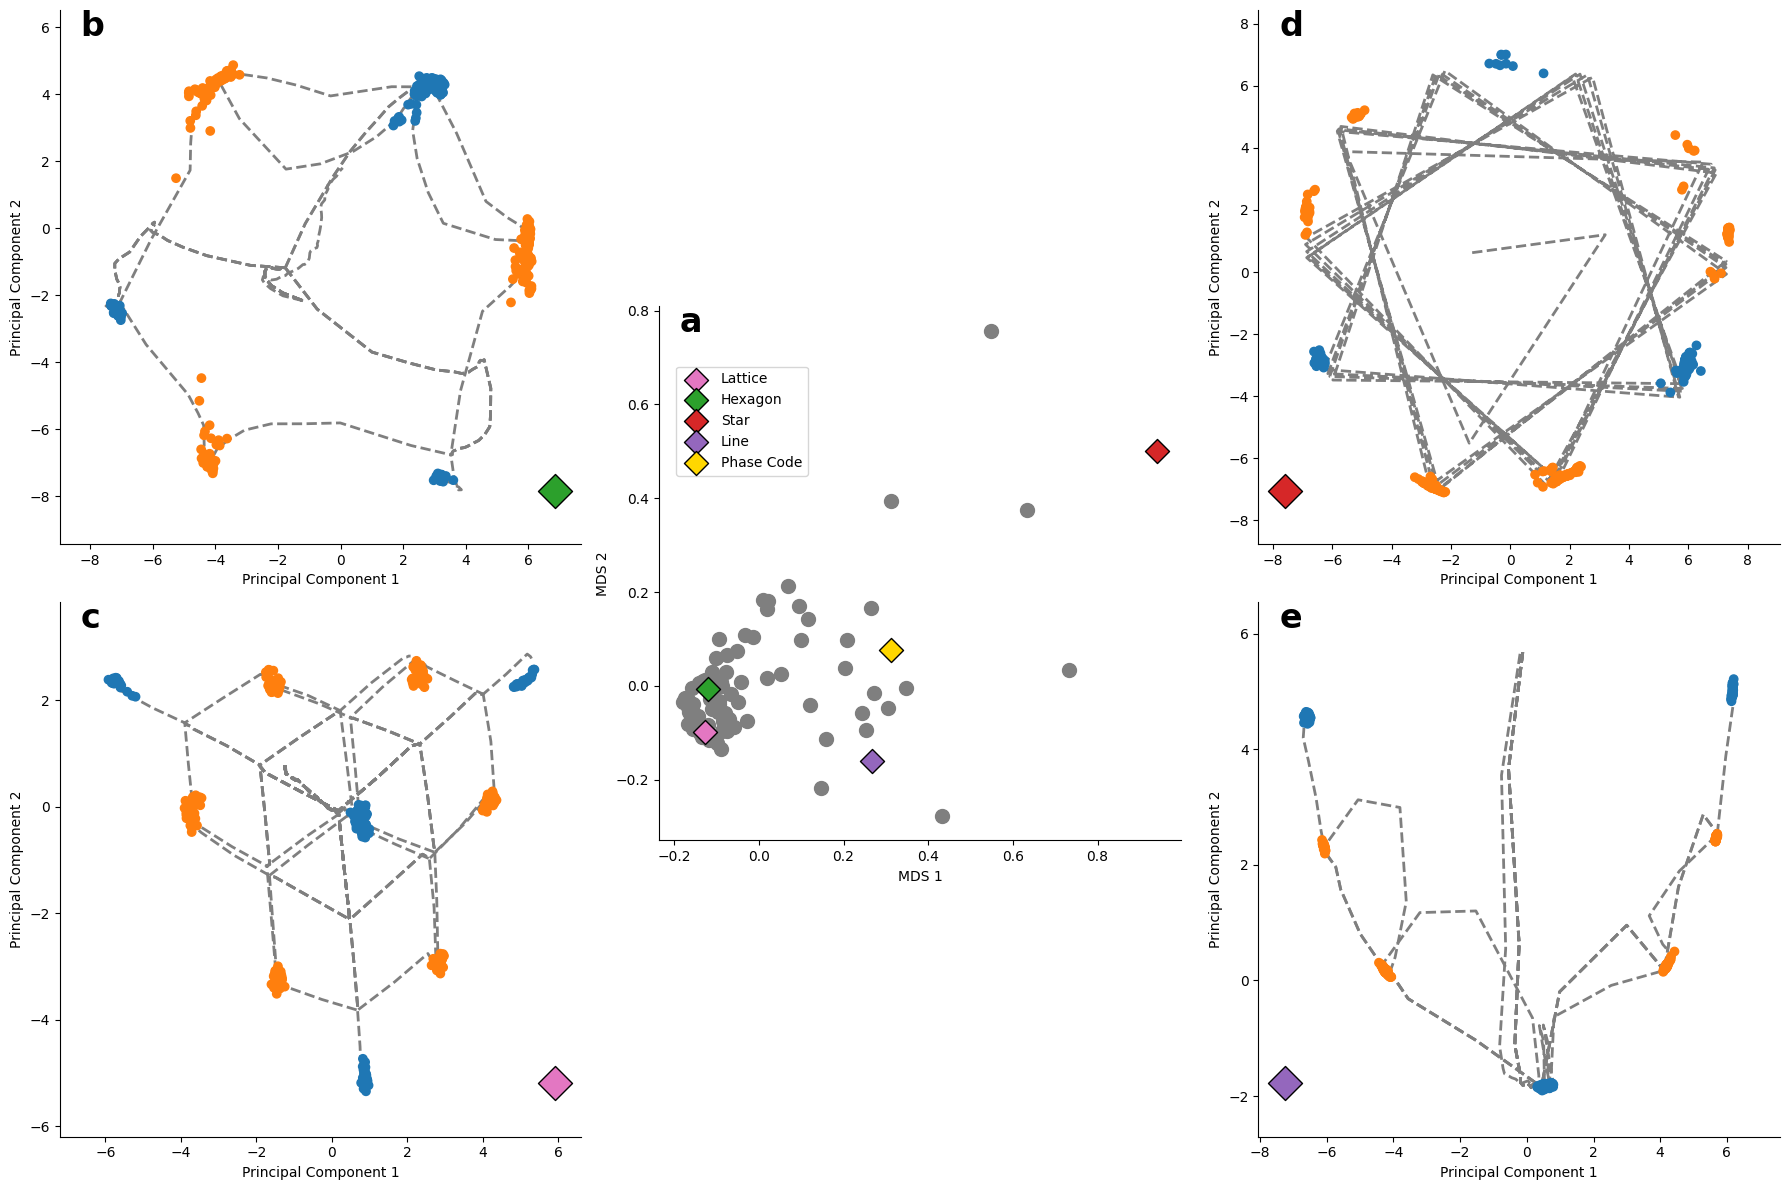

In [7]:
# Create the Figure
fig_anim = plt.figure(figsize=(18, 12))
gs = GridSpec(4, 3)

# Plot MDS embedding
ax_mds = fig_anim.add_subplot(gs[1:3, 1])
for i in range(len(embedding)):
    job_id = val_metrics.iloc[i]["job_id"]
    if job_id in highlighted_jobs:
        style = highlighted_jobs[job_id]
        ax_mds.scatter(
            embedding[i, 0],
            embedding[i, 1],
            c=style["color"],
            marker=style["marker"],
            s=150,
            edgecolors="black",
            zorder=5,
            label=style["label"]
        )
    else:
        ax_mds.scatter(
            embedding[i, 0],
            embedding[i, 1],
            s=100,
            c='tab:grey',
        )

ax_mds.set_xlabel("MDS 1")
ax_mds.set_ylabel("MDS 2")
ax_mds.legend(loc="upper left", bbox_to_anchor=(0.02, 0.9))
ax_mds.spines['top'].set_visible(False)
ax_mds.spines['right'].set_visible(False)

# Plot job_id 52
ax_52 = fig_anim.add_subplot(gs[0:2, 0])
plot_model_dynamics(
    ax_52, 
    val_metrics[val_metrics['job_id'] == 52].iloc[0],
    highlighted_jobs[52],
    [(2,0,1), (2,1,0), (0,0,1), (0,0,2), (1,1,2), (1,1,0), (0,0,0), (1,1,1)],
    [10, 25, 40],
)
ax_52.spines['top'].set_visible(False)
ax_52.spines['right'].set_visible(False)

# Plot job_id 29
ax_29 = fig_anim.add_subplot(gs[2:4, 0])
plot_model_dynamics(
    ax_29, 
    val_metrics[val_metrics['job_id'] == 29].iloc[0],
    highlighted_jobs[29],
    list(product(range(3), repeat=3)),
    [35, 40, 45],
)
ax_29.spines['top'].set_visible(False)
ax_29.spines['right'].set_visible(False)

# Plot job_id 71
ax_71 = fig_anim.add_subplot(gs[0:2, 2])
plot_model_dynamics(
    ax_71, 
    val_metrics[val_metrics['job_id'] == 71].iloc[0],
    highlighted_jobs[71],
    None,
    None,
)
ax_71.spines['top'].set_visible(False)
ax_71.spines['right'].set_visible(False)

# Plot job_id 72
ax_72 = fig_anim.add_subplot(gs[2:4, 2])
plot_model_dynamics(
    ax_72, 
    val_metrics[val_metrics['job_id'] == 72].iloc[0],
    highlighted_jobs[72],
    [(1,1,1), (0,0,0), (1,1,0), (1,0,2), (0,0,1), (0,1,2)],
    [20, 30, 40],
)
ax_72.spines['top'].set_visible(False)
ax_72.spines['right'].set_visible(False)

# Subplot labels with manual coordinates (in axes-relative coordinates)
label_specs = [
    (ax_mds, 'a', (0.04, 1.0)),
    (ax_52, 'b', (0.04, 1.0)),
    (ax_29, 'c', (0.04, 1.0)),
    (ax_71, 'd', (0.04, 1.0)),
    (ax_72, 'e', (0.04, 1.0)),
]

for ax, label, (x, y) in label_specs:
    ax.text(
        x, y, label,
        transform=ax.transAxes,
        fontsize=24,
        fontweight='bold',
        ha='left',
        va='top',
    )

plt.tight_layout()
plt.savefig('../results/solution_space_summary.pdf')
plt.show()